# ブースティング

In [1]:
# 定型ライブラリ読み込み
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import japanize_matplotlib
import scipy
from scipy import stats
from numpy.random import randn
from numpy.random import randint
import copy
import statistics

from sklearn.datasets import load_iris
import pandas as pd

C:\Users\YusukeSato\Anaconda3\lib\site-packages\japanize_matplotlib\japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [2]:
# 別途定義した関数を読み込み
# 試しにこのコードだけ、一部の関数を外だししてみた
from functions import *

In [3]:
# 枝の分割
# 総当たり計算を実施
    # 1. 各変数それぞれに対して
    # 2. あるデータiを選択したときに
    # 3. データiを閾値としてそれより小さいものをleft,以上をrightに格納
    # 4. 分割したときの損失関数を算出
    # 5. 損失関数が過去最少であった場合、閾値とデータ集合を更新
def branch(x, y, S, rf = 0):
    # x:入力データ
    # y:ターゲットデータ
    # S:変数jにおける全データを格納
    # rf:ランダムフォレストを実行する際に利用する変数の数
    if rf == 0:
        T = np.arange(x.shape[1])   # mに変数の個数を格納
    else:
        T = np.random.choice(x.shape[1], rf, replace=False)  # rfは選択する変数の個数を表す
    if x.shape[0] == 0:  # データがないとき？
        return([0,0,0,0,0,0,0])
    
    #print(S)
    
    best_score = np.inf  # スコアをinfに設定し、最小値を探す
    
    for j in T:     # 変数の数だけループ
        for i in S:                 # 後で出てくるコードでSにpoppedを格納している popはオプションなしで指定した配列の最後の要素を取り出す
            left = []; right = []   # 枝の左右を初期化、left,rightはそれぞれの枝に入ったindexのリストである
            for k in S:
                if x[k,j] < x[i,j]:  # 枝の左右への振り分け j番目の変数におけるi番目のデータを閾値としたときの振り分けを実施
                    left.append(k)   # 左に入ったデータのindexのリストに新たにindexを追加
                else:
                    right.append(k)  # 右に入ったデータのindexのリストに新たにindexを追加
            left_score = f(y[left])           # 左側の損失関数を計算
            right_score = f(y[right])         # 右側の損失関数を計算
            score = left_score + right_score  # 合計値をスコアとする
            
            if score < best_score:                                      # スコアが過去のものより良い場合
                best_score = score                                      # スコアの最小値を更新
                i_1 = i; j_1 = j                                        # スコアが前回よりも小さい場合の閾値iと変数jのindexを格納
                left_1 = left; right_1 = right                          # 分割されたデータ集合left,rightのindexを格納
                left_score_1 = left_score; right_score_1 = right_score  # left,rightそれぞれの現時点での最小値を格納
                
    return [i_1, j_1, left_1, right_1, best_score, left_score_1, right_score_1]  # 返却

In [4]:
# ブースティング用の枝を伸ばす関数
def b_dt(x, y, d):
    n = x.shape[0]   # データ数
    node = []        # ノードを初期化
    first = Node(0, -1, 0, np.arange(n))   # 最初のノードを定義
    first.score = f(y[first.set])          # 最初のノードでスコアを算出
    node.append(first)                     # nodeクラスに最初のノードを追加
    
    # ノードの数が規定数に達するまで枝を伸ばす処理を継続
    while len(node) <= 2 * d - 1:
        r = len(node)        # 現時点でのノードの数
        gain_max = -np.inf   # gainを初期化
        
        # 現時点でのノードの数だけループ
        for h in range(r):
            if node[h].j == -1:    # ノードが端点である場合の処理
                i, j, left, right, score, left_score, right_score = branch(x, y, node[h].set)
                gain = node[h].score - score   # gainは現時点でのノードのスコアから新たに計算されたスコアを引く
                # gainがこれまでの最大値よりも大きい場合、値を更新する
                if gain > gain_max:
                    gain_max = gain
                    h_max = h
                    i_0 = i; j_0 = j
                    left_0 = left; right_0 = right
                    left_score_0 = left_score; right_score_0 = right_score
        
        # gainが最大になったノードの値を使って新たなノードを生成する
        node[h_max].th = x[i_0, j_0]; node[h_max].j = j_0
        
        # 左側にノードを生成
        next = Node(h_max, -1, 0, left_0)
        next.score = f(y[next.set]); node.append(next)
        
        # 右側にノードを生成
        next = Node(h_max, -1, 0, right_0)
        next.score = f(y[next.set]); node.append(next)
        
    r = 2 * d + 1
    
    # ノードの分岐を格納するデータをリセット
    for h in range(r):
        node[h].left = 0; node[h].right = 0
    
    # ノードの分岐を格納するデータに値を格納していく
    for h in range(r-1, 1, -1):
        pa = node[h].parent       # node[h]の親ノードをpaに格納
        if node[pa].right == 0:   # node[h]の親ノードの右側にまだ値が格納されていない場合
            node[pa].right = h    # node[h]をその親ノードのrightに格納
        else:                     # そうでない場合
            node[pa].left = h     # node[h]をその親ノードのleftに格納
        if node[h].right == 0 and node[h].left == 0:  # ノードの左右への分岐に値がまだ入っていない場合
            node[h].j = -1                            # ノードに端点フラグを立てる
            
    if f == sq_loss:      # 損失関数を二乗誤差にした場合の処理
        g = np.mean       # 平均値を引数に与える関数とする
    else:
        g = mode_max      # 中央値を引数に与える関数とする
        
    for h in range(r):
        if node[h].j == -1:
            node[h].center = g(node[h].set)
            
    # ???ノードの分岐を格納するデータに値を格納していく
    for h in range(r-1, -1, -1):
        node[h].left = 0; node[h].right = 0
    for h in range(r-1, 0, -1):
        pa = node[h].parent       # node[h]の親ノードをpaに格納
        if node[pa].right == 0:   # node[h]の親ノードの右側にまだ値が格納されていない場合
            node[pa].right = h    # node[h]をその親ノードのrightに格納
        else:                     # そうでない場合
            node[pa].left = h     # node[h]をその親ノードのleftに格納
            
    # ???
    if f == sq_loss:      # 損失関数を二乗誤差にした場合の処理
        g = np.mean       # 平均値を引数に与える関数とする
    else:
        g = mode_max      # 中央値を引数に与える関数とする
        
    for h in range(r):
        if node[h].j == -1:
            node[h].center = g(node[h].set)
        else:
            node[h].center = 0

    return node

## 実行

In [5]:
from sklearn.datasets import load_boston
import pandas as pd

# パラメータ
B = 200
lam = 0.1

# データ読み込み
boston = load_boston()
X = boston.data
y = boston.target
f = sq_loss

# トレーニングセットとテストセットの分割するためのindexリストを生成
train = list(range(200))
test = list(range(200,300))

# 木のセットを初期化
trees_set = []

In [6]:
for d in range(1, 4):
    trees = []
    r = y[train]
    for b in range(B):
        trees.append(b_dt(X[train, :], r, d))
        for i in train:
            r[i] = r[i] - lam*value(X[i, :], trees[b])
        if b%10 == 0:
            print(b)
    print(d)
    trees_set.append(trees)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
1
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
2
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
3


In [18]:
out_set = []
for d in range(1,4):
    trees = trees_set[d-1]
    z = np.zeros((B,600))
    for i in test:
        z[0, i] = lam * value(X[i, :], trees[0])
        for b in range(1,B):
            for j in test:
                z[b, j] = z[b-1, j] + lam * value(X[j, :], trees[b])
    out = []
    for b in range(B):
        out.append(sum((y[test] - z[b, test])**2)/len(test))
    out_set.append(out)

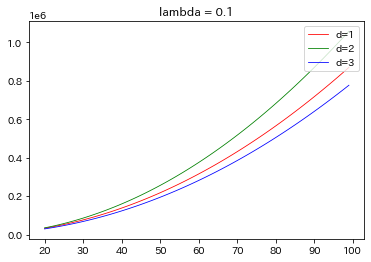

In [19]:
#plt.ylim([0, 40])
c_seq = ['r', 'g', 'b']
label_seq = ['d=1', 'd=2', 'd=3']
plt.xlabel = ('生成した木の個数')
plt.ylabel = ('テストデータでの二乗誤差')
plt.title('lambda = 0.1')

for d in range(1, 4):
    out = out_set[d - 1]
    u = range(20, 100)
    v = out[20:100]
    plt.plot(u,
             v,
             label = label_seq[d-1],
             linewidth = 0.8,
             c = c_seq[d-1])
plt.legend(loc = 'upper right')

# ???? 本書と同じようにならない

## lightgbmを使った場合

In [25]:
import lightgbm as lgb

In [28]:
from sklearn.datasets import load_boston
import pandas as pd

boston = load_boston()
X = boston.data
y = boston.target

train = list(range(200))
test = list(range(200,300))

lgb_train = lgb.Dataset(X[train,:], y[train])
lgb_eval = lgb.Dataset(X[test,:], y[test], reference = lgb_train)
B = 5000
nn_seq = list(range(1, 10, 1)) + list(range(10, 91, 10)) + list(range(100, B, 50))

out_set = []

for d in range(1, 4):
    lgbm_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': d+1,
        'learning_rate': 0.001
    }
    out = []
    for nn in nn_seq:
        model = lgb.train(lgbm_params,
                          lgb_train,
                          valid_sets = lgb_eval,
                          verbose_eval = False,
                          num_boost_round = nn)
        z = model.predict(X[test, :], num_iteration = model.best_iteration)
        out.append(sum((z - y[test])**2)/100)
    out_set.append(out)

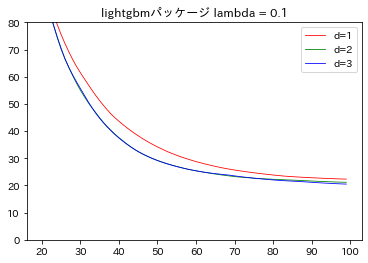

In [29]:
plt.ylim([0, 80])
c_seq = ['r', 'g', 'b']
label_seq = ['d=1', 'd=2', 'd=3']
plt.xlabel = ('生成した木の個数')
plt.ylabel = ('テストデータでの二乗誤差')
plt.title('lightgbmパッケージ lambda = 0.1')

for d in range(1, 4):
    out = out_set[d - 1]
    u = range(20, 100)
    v = out[20:100]
    plt.plot(u,
             v,
             label = label_seq[d-1],
             linewidth = 0.8,
             c = c_seq[d-1])
plt.legend(loc = 'upper right')

## 本書と同じ感じになった